# DATA PROCESSING

In [ ]:
# importing libraries

import pandas as pd
import numpy as np

In [2]:
# read images (x) data

import pathlib
from skimage.io import imread_collection, imshow

training_ims = [str(i) for i in pathlib.Path('../../data/understanding_cloud_organization/train_images_350x525').glob('*.jpg')]

X = np.array(imread_collection(training_ims, conserve_memory = True))
X.shape

(5546, 350, 525, 3)

In [3]:
# grayscale images (x) data

from skimage.color import rgb2gray

Xg = np.array(list(map(lambda x: rgb2gray(x), X)))
Xg.shape

(5546, 350, 525)

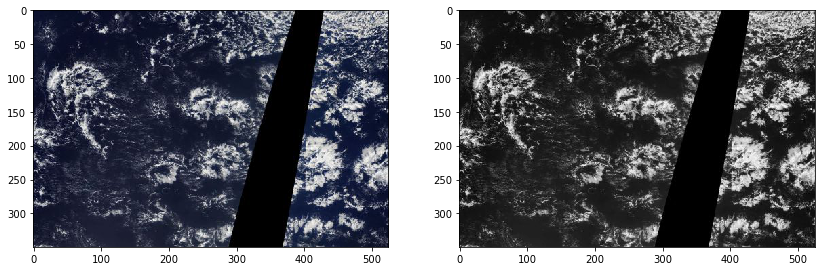

In [5]:
# compare color and grayscale images

from matplotlib import pyplot as plt

fig, axes = plt.subplots(1, 2, figsize = (14, 25))
axes[0].imshow(X[1])
axes[1].imshow(Xg[1], cmap = 'gray')

In [6]:
y_rle = pd.read_csv('../../data/understanding_cloud_organization/train.csv')
y_rle[['Image', 'Label']] = y_rle['Image_Label'].str.split('_', expand = True)
y_rle = y_rle[['Image', 'Label', 'EncodedPixels']]
y_rle.head()

,Image,Label,EncodedPixels
0,0011165.jpg,Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg,Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg,Gravel,NaN
3,0011165.jpg,Sugar,NaN
4,002be4f.jpg,Fish,233813 878 235213 878 236613 878 238010 881 23...


In [7]:
# read labels (y) data

y = pd.read_csv('../../data/understanding_cloud_organization/train.csv').fillna(0)
y.loc[y['EncodedPixels'] != 0, 'EncodedPixels'] = 1
y[['Image', 'Label']] = y['Image_Label'].str.split('_', expand = True)
y = y[['Image', 'Label', 'EncodedPixels']].pivot(index = 'Image', columns = 'Label', values = 'EncodedPixels')
y = y.reset_index(drop = True)
del y.columns.name
y.head()

,Fish,Flower,Gravel,Sugar
0,1,1,0,0
1,1,1,0,1
2,1,1,0,1
3,0,1,1,0
4,1,0,1,1


# DESCRIPTIVES

In [251]:
count_y = pd.DataFrame(y.sum(axis = 0))
count_y.columns = ['Count']
count_y['Label'] = ['Fish', 'Flower', 'Gravel', 'Sugar']
count_y

,Count,Label
0,2781,Fish
1,2365,Flower
2,2939,Gravel
3,3751,Sugar


In [252]:
count_x = pd.DataFrame(y.sum(axis = 1))
count_x.columns = ['Patterns']
count_x['Count'] = count_x['Patterns']
count_x = count_x.groupby('Patterns').count().reset_index()
count_x

,Patterns,Count
0,1,1348
1,2,2372
2,3,1560
3,4,266


In [67]:
singles = y[y_train.sum(axis = 1) == 1]
fish_only = singles[singles['Fish'] == 1].index[:4]
flower_only = singles[singles['Flower'] == 1].index[:4]
gravel_only = singles[singles['Gravel'] == 1].index[:4]
sugar_only = singles[singles['Sugar'] == 1].index[:4]

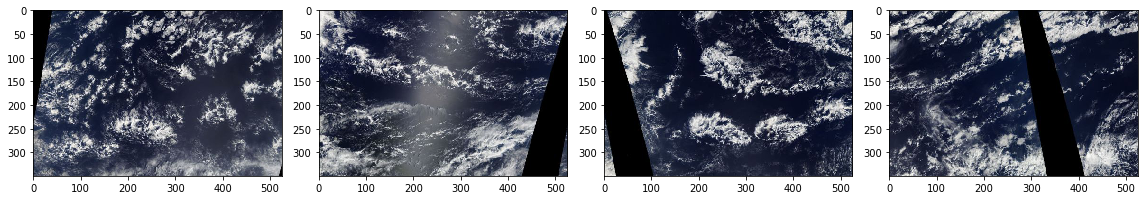

In [92]:
from matplotlib import pyplot as plt

rows = 1
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
fig.tight_layout()

for i, j in enumerate(X[fish_only][:4]):
    imshow(j, ax = axes[i])

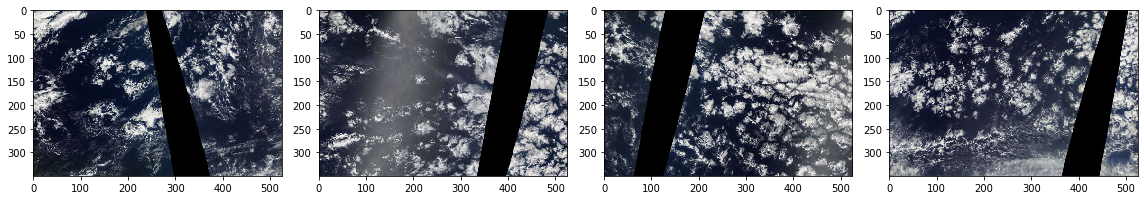

In [93]:
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
fig.tight_layout()

for i, j in enumerate(X[flower_only][:4]):
    imshow(j, ax = axes[i])

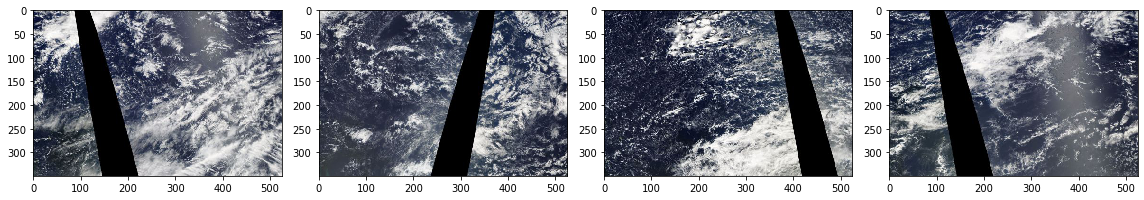

In [94]:
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
fig.tight_layout()

for i, j in enumerate(X[gravel_only][:4]):
    imshow(j, ax = axes[i])

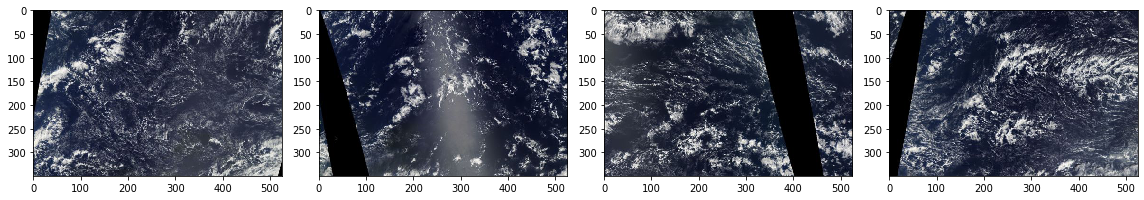

In [95]:
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
fig.tight_layout()

for i, j in enumerate(X[sugar_only][:4]):
    imshow(j, ax = axes[i])

# NEURAL NETWORK

In [8]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = DeprecationWarning)

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.activations import relu, sigmoid
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

Using TensorFlow backend.


In [15]:
# split training and testing data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .8)
Xg_train, Xg_test, yg_train, yg_test = train_test_split(Xg, y, train_size = .8)

In [ ]:
# scale features

from sklearn.preprocessing import StandardScaler

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)
Xg_train = StandardScaler().fit_transform(Xg_train)
Xg_test = StandardScaler().fit_transform(Xg_test)

In [209]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation = relu, input_shape = Xg_train[0].shape))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(.2))

model.add(Conv2D(32, (3, 3), activation = relu))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(.3))

model.add(Conv2D(64, (3, 3), activation = relu))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(.4))

model.add(Conv2D(128, (3, 3), activation = relu))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(.5))

model.add(Flatten())

model.add(Dense(128, activation = relu))
model.add(BatchNormalization())
model.add(Dropout(.5))

model.add(Dense(128, activation = relu))
model.add(BatchNormalization())
model.add(Dropout(.5))

model.add(Dense(4, activation = sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_104 (Conv2D)          (None, 348, 523, 16)      448       
_________________________________________________________________
batch_normalization_64 (Batc (None, 348, 523, 16)      64        
_________________________________________________________________
max_pooling2d_103 (MaxPoolin (None, 174, 261, 16)      0         
_________________________________________________________________
dropout_105 (Dropout)        (None, 174, 261, 16)      0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 172, 259, 32)      4640      
_________________________________________________________________
batch_normalization_65 (Batc (None, 172, 259, 32)      128       
_________________________________________________________________
max_pooling2d_104 (MaxPoolin (None, 86, 129, 32)       0         
__________

In [208]:
model1.compile(loss = binary_crossentropy, optimizer = Adam(lr = .01), metrics = ['accuracy'])
history8 = model1.fit(X_train, y_train, epochs = 20, validation_data = (X_test, y_test))

Train on 4436 samples, validate on 1110 samples
Epoch 1/20
4436/4436 [==============================] - 1161s 262ms/step - loss: 0.7456 - acc: 0.5654 - val_loss: 1.0826 - val_acc: 0.4745
Epoch 2/20
4436/4436 [==============================] - 3122s 704ms/step - loss: 0.6689 - acc: 0.5968 - val_loss: 1.5924 - val_acc: 0.4273
Epoch 3/20
4436/4436 [==============================] - 1105s 249ms/step - loss: 0.6168 - acc: 0.6584 - val_loss: 0.6553 - val_acc: 0.6011
Epoch 4/20
4436/4436 [==============================] - 1312s 296ms/step - loss: 0.5932 - acc: 0.6799 - val_loss: 0.6015 - val_acc: 0.6682
Epoch 5/20
4436/4436 [==============================] - 672s 151ms/step - loss: 0.5758 - acc: 0.6939 - val_loss: 0.8934 - val_acc: 0.5959
Epoch 6/20
4436/4436 [==============================] - 702s 158ms/step - loss: 0.5617 - acc: 0.7054 - val_loss: 1.6426 - val_acc: 0.5691
Epoch 7/20
4436/4436 [==============================] - 673s 152ms/step - loss: 0.5488 - acc: 0.7160 - val_loss: 0.6791 

In [ ]:
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > .5)

In [ ]:
from sklearn.metrics import confusion_matrix

def plotConfusionMatrix(matrix):
    ax = sns.heatmap(matrix, cmap = 'Blues', annot = True, fmt = 'd')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

In [ ]:
def plotLearningCurve(history, epoch):
    
    # plot training & validation accuracy values
    epochs = range(1, epoch + 1)
    plt.plot(epochs, history.history['accuracy'])
    plt.plot(epochs, history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc = 'upper left')
    plt.show()
    
    # plot training & validation loss values
    plt.plot(epochs, history.history['loss'])
    plt.plot(epochs, history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc = 'upper left')
    plt.show()

In [ ]:
plotConfusionMatrix()

In [ ]:
plotLearningCurve()